# **1. Data preprocessing and visualization**

In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from time import perf_counter
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score
from IPython.display import Markdown, display

def printmd(string):
    # Print with Markdowns    
    display(Markdown(string))
    
    

In [3]:
# Create a list with the filepaths for training and testing
dir_ = Path('../input/asl-alphabet/asl_alphabet_train')
file_paths = list(dir_.glob(r'**/*.jpg'))

In [5]:
def proc_img(filepath):
    """ Create a DataFrame with the filepath and the labels of the pictures
    """

    labels = [str(filepath[i]).split("/")[-2] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name = 'Filepath').astype(str)
    labels = pd.Series(labels, name = 'Label')

    # Concatenate filepaths and labels
    df = pd.concat([filepath, labels], axis = 1)

    # Shuffle the DataFrame and reset index
    df = df.sample(frac = 1, random_state = 0).reset_index(drop = True)
    
    return df

df = proc_img(file_paths)

print(f'Number of pictures in the dataset: {df.shape[0]}\n')
print(f'Number of different labels: {len(df.Label.unique())}\n')
print(f'Labels: {df.Label.unique()}')

# The DataFrame with the filepaths in one column and the labels in the other one
df.head(5)

Number of pictures in the dataset: 87000

Number of different labels: 29

Labels: ['W' 'del' 'G' 'X' 'Y' 'space' 'K' 'I' 'H' 'E' 'P' 'J' 'nothing' 'Q' 'S'
 'A' 'C' 'T' 'L' 'M' 'N' 'F' 'B' 'D' 'R' 'O' 'Z' 'V' 'U']


,Filepath,Label
0,../input/asl-alphabet/asl_alphabet_train/asl_a...,W
1,../input/asl-alphabet/asl_alphabet_train/asl_a...,del
2,../input/asl-alphabet/asl_alphabet_train/asl_a...,G
3,../input/asl-alphabet/asl_alphabet_train/asl_a...,X
4,../input/asl-alphabet/asl_alphabet_train/asl_a...,Y


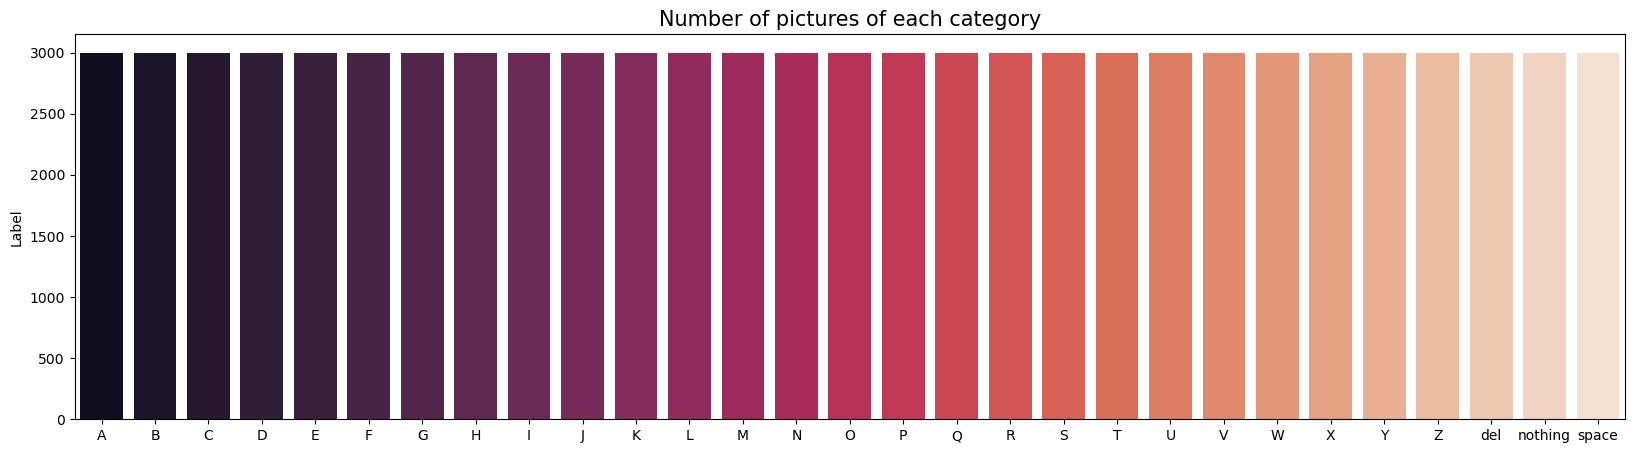

In [6]:
# Display the number of pictures of each category
vc = df['Label'].value_counts()
plt.figure(figsize = (20,5))
sns.barplot(x = sorted(vc.index), y = vc, palette = "rocket")
plt.title("Number of pictures of each category", fontsize = 15)
plt.show()

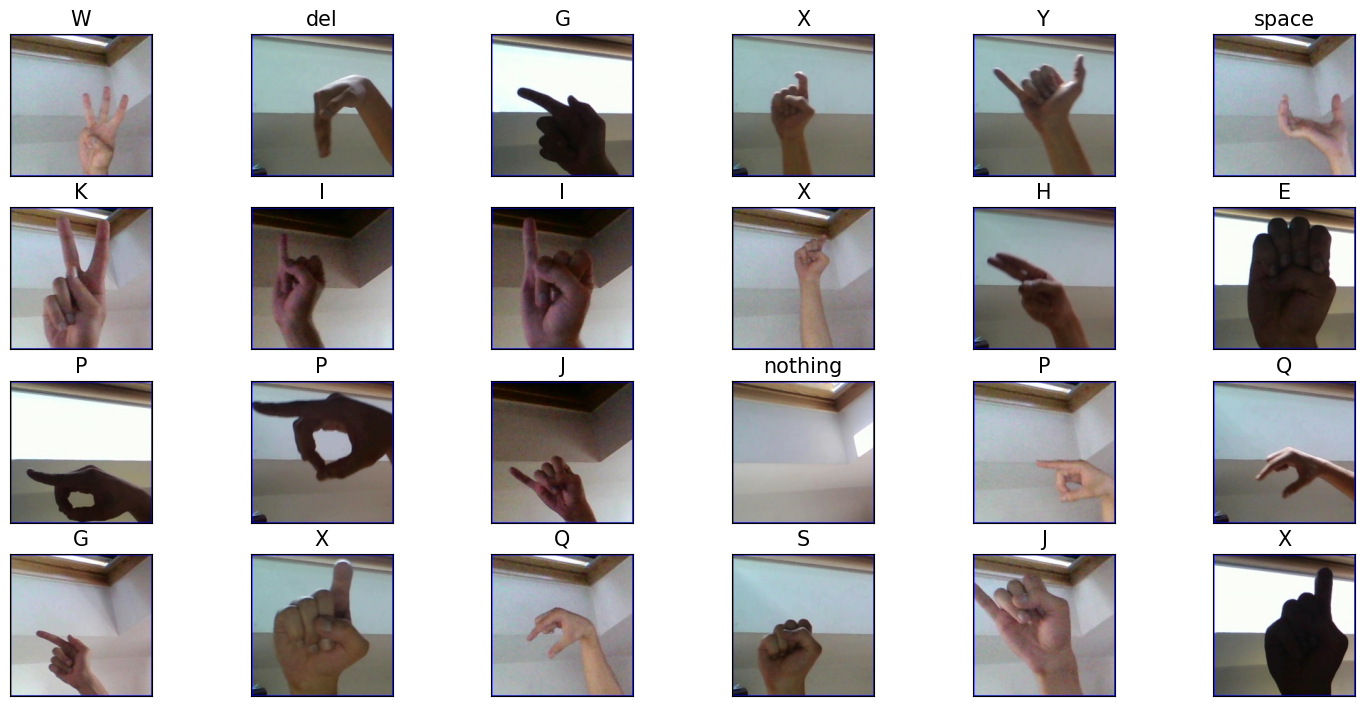

In [7]:
# Display some pictures of the dataset
fig, axes = plt.subplots(nrows = 4, ncols = 6, figsize = (15, 7),
                         subplot_kw = {'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df.Filepath[i]))
    ax.set_title(df.Label[i], fontsize = 15)
plt.tight_layout(pad = 0.5)
plt.show()

In [10]:
# Use 5% of the dataset for testing various models
# Split into training and test datasets
train_df, test_df = train_test_split(df.sample(frac = 0.05), test_size = 0.2, random_state = 0)

# **2. Load the Images with a generator and Data Augmentation**

In [12]:
def create_gen():
    # Load the Images with a generator and Data Augmentation
    train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function = tf.keras.applications.mobilenet_v2.preprocess_input,
        validation_split = 0.1
    )

    test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function = tf.keras.applications.mobilenet_v2.preprocess_input
    )

    train_images = train_generator.flow_from_dataframe(
        dataframe = train_df,
        x_col = 'Filepath',
        y_col = 'Label',
        target_size = (224, 224),
        color_mode = 'rgb',
        class_mode = 'categorical',
        batch_size = 32,
        shuffle = True,
        seed = 0,
        subset = 'training',
#         rotation_range = 30, # Uncomment to use data augmentation
#         zoom_range = 0.15,
#         width_shift_range = 0.2,
#         height_shift_range = 0.2,
#         shear_range = 0.15,
#         horizontal_flip = True,
#         fill_mode = "nearest"
    )

    val_images = train_generator.flow_from_dataframe(
        dataframe = train_df,
        x_col = 'Filepath',
        y_col = 'Label',
        target_size = (224, 224),
        color_mode = 'rgb',
        class_mode = 'categorical',
        batch_size = 32,
        shuffle = True,
        seed = 0,
        subset = 'validation',
#         rotation_range = 30, # Uncomment to use data augmentation
#         zoom_range = 0.15,
#         width_shift_range = 0.2,
#         height_shift_range = 0.2,
#         shear_range = 0.15,
#         horizontal_flip = True,
#         fill_mode = "nearest"
    )

    test_images = test_generator.flow_from_dataframe(
        dataframe = test_df,
        x_col = 'Filepath',
        y_col = 'Label',
        target_size = (224, 224),
        color_mode = 'rgb',
        class_mode = 'categorical',
        batch_size = 32,
        shuffle = False
    )
    
    return train_generator, test_generator, train_images, val_images, test_images

# **3. Test 27 canned architectures with pre-trained weights**

In [16]:
def get_and_compile_model(model_class):
# Load the pretrained model
    kwargs = {
        'input_shape': (224, 224, 3),
        'include_top': False,
        'weights': 'imagenet',
        'pooling': 'avg'
    }

    pretrained_model = model_class(**kwargs)
    pretrained_model.trainable = False
    
    inputs = pretrained_model.input
    
    x = tf.keras.layers.Dense(128, activation = 'relu')(pretrained_model.output)
    x = tf.keras.layers.Dense(128, activation = 'relu')(x)
    outputs = tf.keras.layers.Dense(29, activation = 'softmax')(x)

    model = tf.keras.Model(inputs = inputs, outputs = outputs)

    optimizer = tf.keras.optimizers.Adam(
        learning_rate = 0.001, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-08)

    model.compile(
        optimizer = optimizer,
        loss = 'categorical_crossentropy',
        metrics = ['accuracy']
    )

    return model

In [17]:
# Dictionary with the models
models = {
    "DenseNet121" : {"model" : tf.keras.applications.DenseNet121, "perf" : 0},
    "DenseNet169" : {"model" : tf.keras.applications.DenseNet169, "perf" : 0},
    "DenseNet201" : {"model" : tf.keras.applications.DenseNet201, "perf" : 0},
    "EfficientNetB0" : {"model" : tf.keras.applications.EfficientNetB0, "perf" : 0},
    "EfficientNetB1" : {"model" : tf.keras.applications.EfficientNetB1, "perf" : 0},
    "EfficientNetB2" : {"model" : tf.keras.applications.EfficientNetB2, "perf" : 0},
    "EfficientNetB3" : {"model" : tf.keras.applications.EfficientNetB3, "perf" : 0},
    "EfficientNetB4" : {"model" : tf.keras.applications.EfficientNetB4, "perf" : 0},
    "EfficientNetB5" : {"model" : tf.keras.applications.EfficientNetB5, "perf" : 0},
    "EfficientNetB6" : {"model" : tf.keras.applications.EfficientNetB6, "perf" : 0},
    "EfficientNetB7" : {"model" : tf.keras.applications.EfficientNetB7, "perf" : 0},
    "InceptionResNetV2" : {"model" : tf.keras.applications.InceptionResNetV2, "perf" : 0},
    "InceptionV3" : {"model" : tf.keras.applications.InceptionV3, "perf" : 0},
    "MobileNet" : {"model" : tf.keras.applications.MobileNet, "perf" : 0},
    "MobileNetV2" : {"model" : tf.keras.applications.MobileNetV2, "perf" : 0},
    "MobileNetV3Large" : {"model" : tf.keras.applications.MobileNetV3Large, "perf" : 0},
    "MobileNetV3Small" : {"model" : tf.keras.applications.MobileNetV3Small, "perf" : 0},
    "NASNetMobile" : {"model" : tf.keras.applications.NASNetMobile, "perf" : 0},
    "ResNet101" : {"model" : tf.keras.applications.ResNet101, "perf" : 0},
    "ResNet101V2" : {"model" : tf.keras.applications.ResNet101V2, "perf" : 0},
    "ResNet152" : {"model" : tf.keras.applications.ResNet152, "perf" : 0},
    "ResNet152V2" : {"model" : tf.keras.applications.ResNet152V2, "perf" : 0},
    "ResNet50" : {"model" : tf.keras.applications.ResNet50, "perf" : 0},
    "ResNet50V2" : {"model" : tf.keras.applications.ResNet50V2, "perf" : 0},
    "VGG16" : {"model" : tf.keras.applications.VGG16, "perf" : 0},
    "VGG19" : {"model" : tf.keras.applications.VGG19, "perf" : 0},
    "Xception" : {"model" : tf.keras.applications.Xception, "perf" : 0}
}

# Create the generators
train_generator, test_generator, train_images, val_images, test_images = create_gen()
print('\n')

# Fit the models
for name, model in models.items():
    
    # Get and compile the model
    m = get_and_compile_model(model['model'])
    models[name]['model'] = m
    
    start = perf_counter()
    
    # Fit the model
    history = m.fit(train_images, validation_data = val_images, epochs = 5, verbose = 0)
    
    # Save the duration and the val_accuracy
    duration = perf_counter() - start
    duration = round(duration, 2)
    models[name]['perf'] = duration
    print(f"{name:20} trained in {duration} sec")
    
    val_acc = history.history['val_accuracy']
    models[name]['val_acc'] = [round(v, 4) for v in val_acc]
    
    tf.keras.backend.clear_session()

Found 3132 validated image filenames belonging to 29 classes.
Found 348 validated image filenames belonging to 29 classes.
Found 870 validated image filenames belonging to 29 classes.


29084464/29084464 [==============================] - 2s 0us/step
DenseNet121          trained in 78.9 sec
51877672/51877672 [==============================] - 2s 0us/step
DenseNet169          trained in 54.79 sec
74836368/74836368 [==============================] - 3s 0us/step
DenseNet201          trained in 65.52 sec
16705208/16705208 [==============================] - 1s 0us/step


2023-08-11 08:11:31.929921: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


EfficientNetB0       trained in 49.92 sec
27018416/27018416 [==============================] - 1s 0us/step


2023-08-11 08:12:29.712974: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


EfficientNetB1       trained in 63.79 sec
31790344/31790344 [==============================] - 2s 0us/step


2023-08-11 08:13:37.566633: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


EfficientNetB2       trained in 62.99 sec
43941136/43941136 [==============================] - 2s 0us/step


2023-08-11 08:14:48.620769: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


EfficientNetB3       trained in 67.43 sec
71686520/71686520 [==============================] - 3s 0us/step


2023-08-11 08:16:04.276222: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


EfficientNetB4       trained in 95.37 sec
115263384/115263384 [==============================] - 4s 0us/step


2023-08-11 08:17:52.297115: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


EfficientNetB5       trained in 105.46 sec
165234480/165234480 [==============================] - 6s 0us/step


2023-08-11 08:19:51.394715: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


EfficientNetB6       trained in 119.13 sec
258076736/258076736 [==============================] - 8s 0us/step


2023-08-11 08:22:12.248967: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


EfficientNetB7       trained in 160.48 sec
219055592/219055592 [==============================] - 7s 0us/step
InceptionResNetV2    trained in 95.11 sec
87910968/87910968 [==============================] - 3s 0us/step
InceptionV3          trained in 48.83 sec
17225924/17225924 [==============================] - 1s 0us/step
MobileNet            trained in 43.74 sec
9406464/9406464 [==============================] - 1s 0us/step
MobileNetV2          trained in 49.81 sec
12683000/12683000 [==============================] - 1s 0us/step
MobileNetV3Large     trained in 49.01 sec
4334752/4334752 [==============================] - 1s 0us/step
MobileNetV3Small     trained in 51.46 sec
19993432/19993432 [==============================] - 1s 0us/step
NASNetMobile         trained in 61.88 sec
171446536/171446536 [==============================] - 7s 0us/step
ResNet101            trained in 89.67 sec
171317808/171317808 [==============================] - 6s 0us/step
ResNet101V2          trained in 77

In [19]:
# Create a DataFrame with the results
models_result = []

for name, v in models.items():
    models_result.append([name, models[name]['val_acc'][-1], 
                          models[name]['perf']])
    
df_results = pd.DataFrame(models_result, 
                          columns = ['model', 'val_accuracy', 'Training time (sec)'])
df_results.sort_values(by = 'val_accuracy', ascending = False, inplace = True)
df_results.reset_index(inplace = True, drop = True)
df_results

,model,val_accuracy,Training time (sec)
0,MobileNet,0.9770,43.74
1,DenseNet169,0.9540,54.79
2,DenseNet201,0.9511,65.52
3,MobileNetV2,0.9483,49.81
4,ResNet50V2,0.9397,46.05
5,ResNet101V2,0.9397,77.79
6,DenseNet121,0.9167,78.90
7,ResNet152V2,0.9052,93.54
8,Xception,0.9023,61.23
9,NASNetMobile,0.8764,61.88


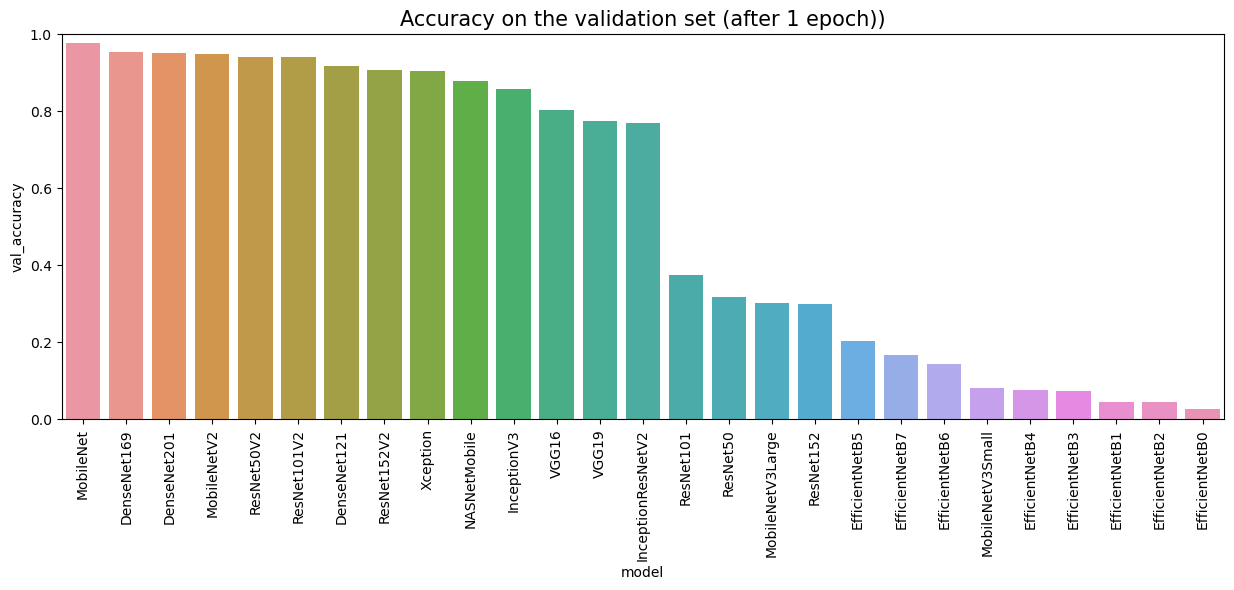

In [20]:
plt.figure(figsize = (15, 5))
sns.barplot(x = 'model', y = 'val_accuracy', data = df_results)
plt.title('Accuracy on the validation set (after 1 epoch))', fontsize = 15)
plt.ylim(0, 1)
plt.xticks(rotation = 90)
plt.show()

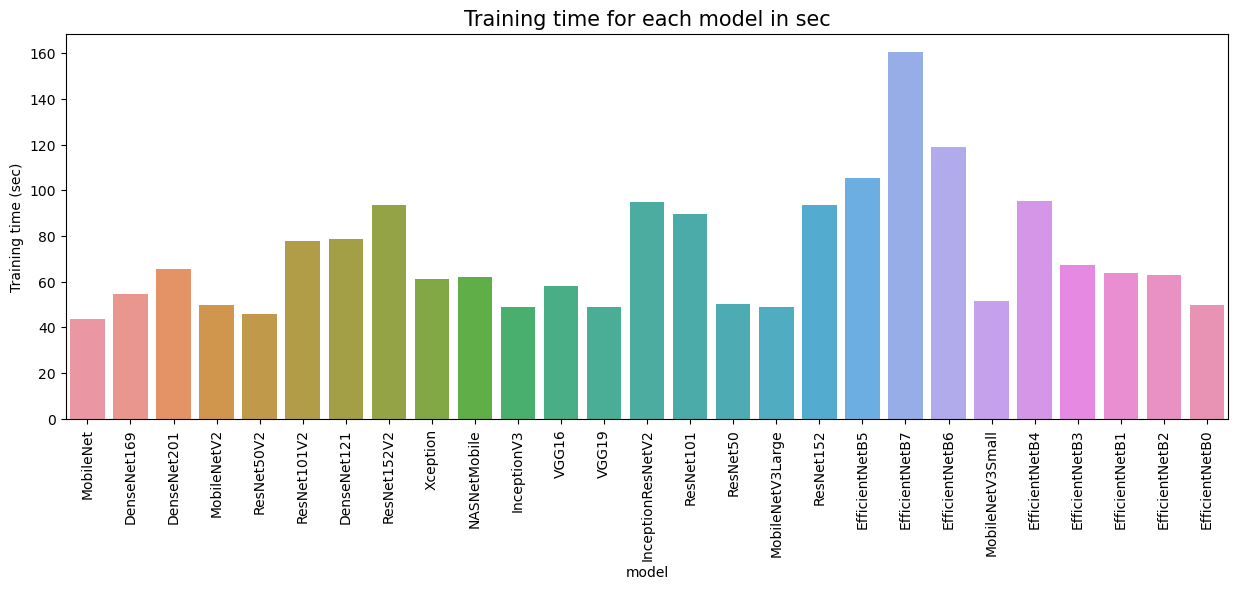

In [21]:
plt.figure(figsize = (15, 5))
sns.barplot(x = 'model', y = 'Training time (sec)', data = df_results)
plt.title('Training time for each model in sec', fontsize = 15)
plt.xticks(rotation = 90)
plt.show()

# **4. Train the architecture with the best result**

In [28]:
# Use the whole data which is split into training and test datasets
train_df, test_df = train_test_split(df, test_size = 0.1, random_state = 0)

# Create the generators
train_generator, test_generator, train_images, val_images, test_images = create_gen()

# Get the model with the highest validation score
best_model = df_results.iloc[0]

# Create a new model
model = get_and_compile_model( eval("tf.keras.applications."+ best_model[0]) )

# Train the model
history = model.fit(train_images,
                    validation_data = val_images,
                    epochs = 5,
                    callbacks = [
                        tf.keras.callbacks.EarlyStopping(
                            monitor = 'val_loss',
                            patience = 1,
                            verbose = 1,
                            restore_best_weights = True)]
                    )

# Save the model
model.save('Best_Pretrained_Model_ASL_Alphabet.h5')
print('Model Saved!')

Found 70470 validated image filenames belonging to 29 classes.
Found 7830 validated image filenames belonging to 29 classes.
Found 8700 validated image filenames belonging to 29 classes.
Epoch 1/5
2203/2203 [==============================] - 168s 75ms/step - loss: 0.1657 - accuracy: 0.9548 - val_loss: 0.0390 - val_accuracy: 0.9879
Epoch 2/5
2203/2203 [==============================] - 159s 72ms/step - loss: 0.0281 - accuracy: 0.9906 - val_loss: 0.0320 - val_accuracy: 0.9888
Epoch 3/5
2203/2203 [==============================] - 172s 78ms/step - loss: 0.0220 - accuracy: 0.9926 - val_loss: 0.0164 - val_accuracy: 0.9946
Epoch 4/5
2203/2203 [==============================] - 170s 77ms/step - loss: 0.0215 - accuracy: 0.9931 - val_loss: 0.0095 - val_accuracy: 0.9971
Epoch 5/5
2203/2203 [==============================] - 172s 78ms/step - loss: 0.0160 - accuracy: 0.9949 - val_loss: 0.0345 - val_accuracy: 0.9909
Epoch 5: early stopping
Model Saved!


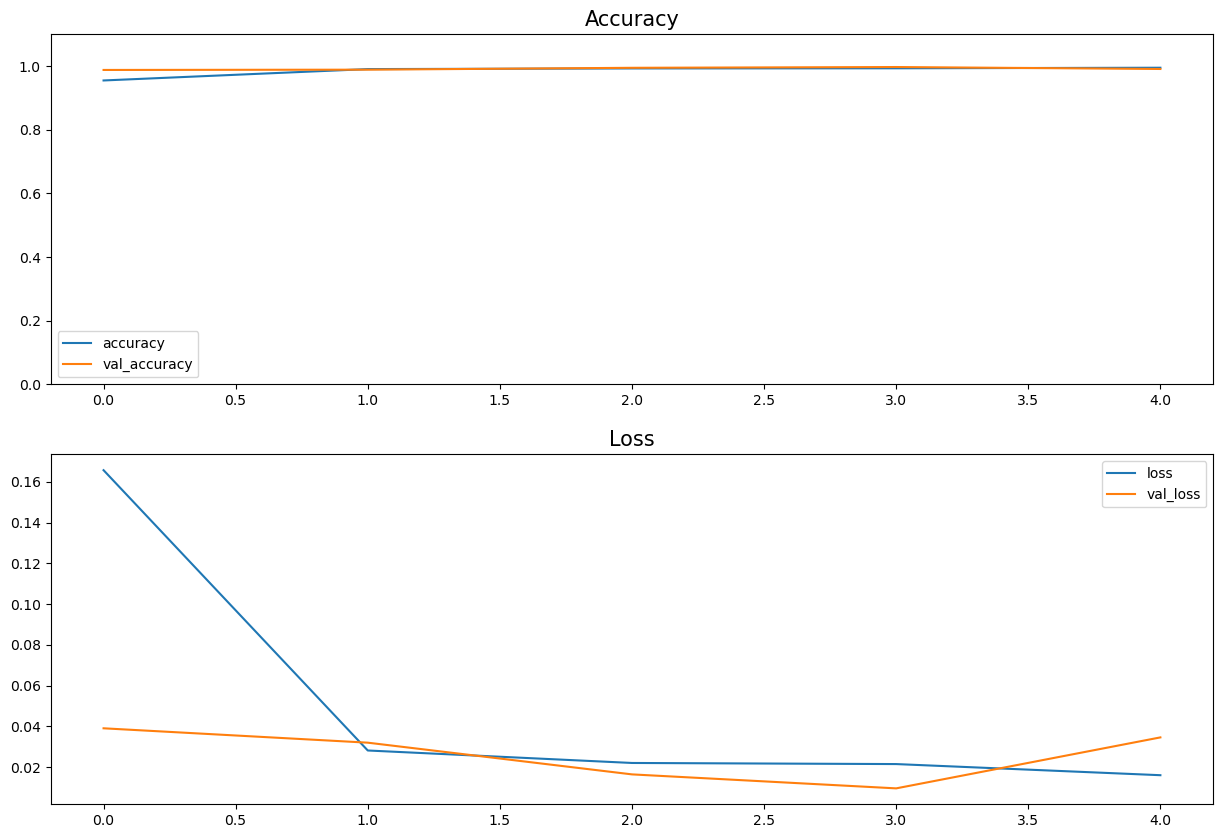

In [29]:
fig, axes = plt.subplots(2, 1, figsize = (15, 10))
ax = axes.flat

pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot(ax = ax[0])
ax[0].set_title("Accuracy", fontsize = 15)
ax[0].set_ylim(0, 1.1)

pd.DataFrame(history.history)[['loss', 'val_loss']].plot(ax = ax[1])
ax[1].set_title("Loss", fontsize = 15)
plt.show()

272/272 [==============================] - 76s 278ms/step
## Best Model: MobileNet with 99.54% accuracy on the test set


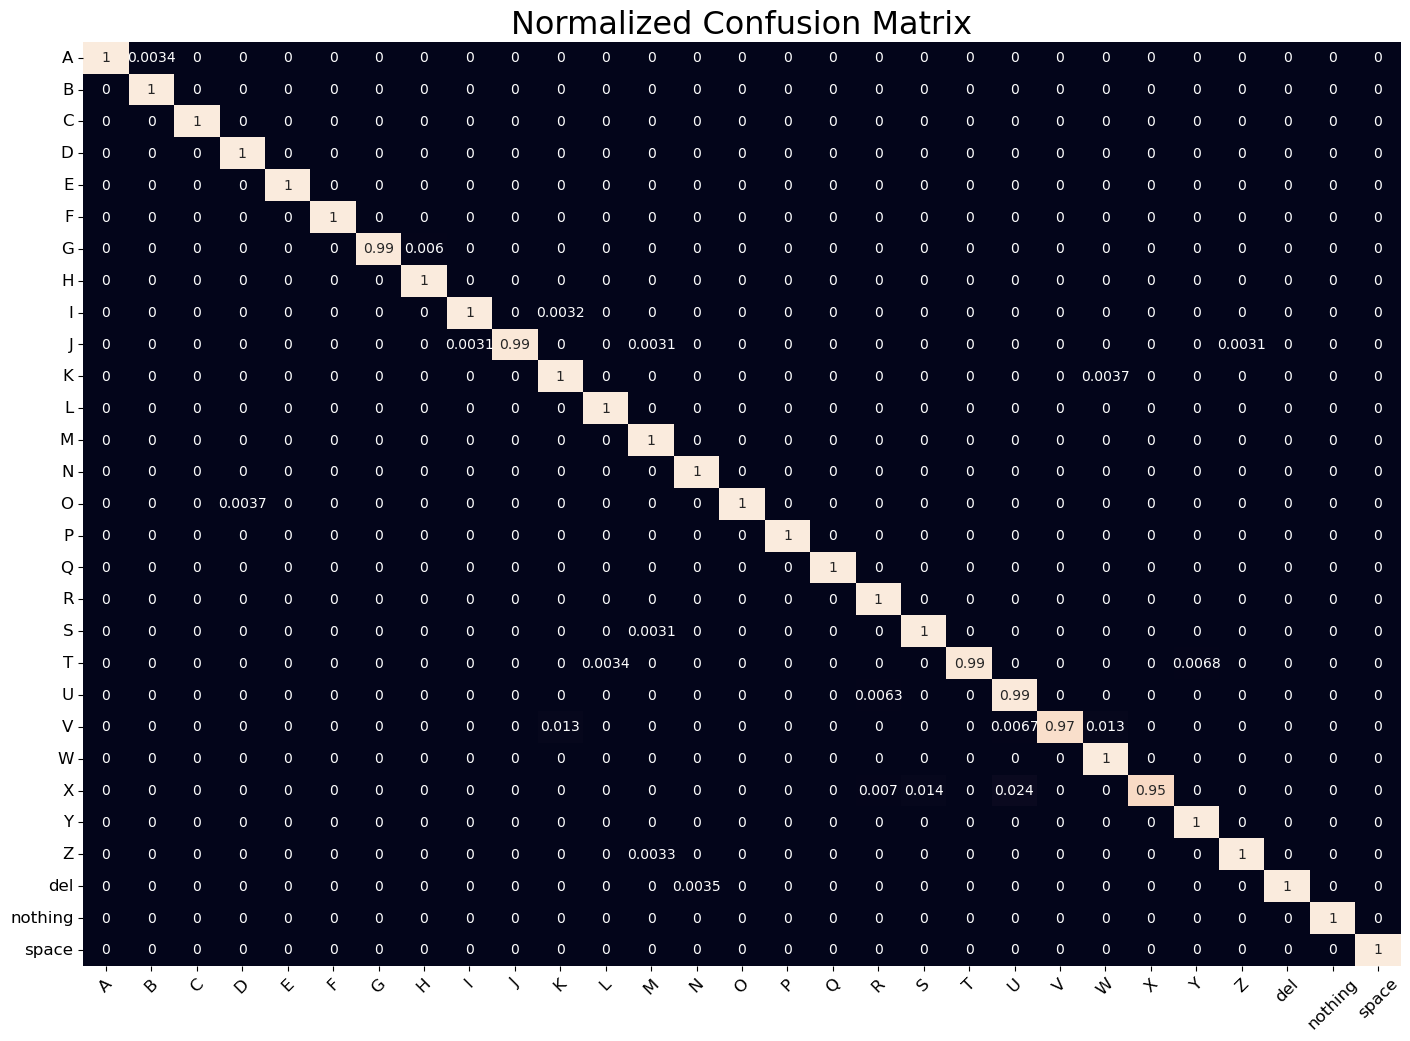

In [30]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred, axis = 1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v, k) for k, v in labels.items())
pred = [labels[k] for k in pred]

# Get the accuracy on the test set
y_test = list(test_df.Label)
acc = accuracy_score(y_test, pred)

# Display the results
print(f'## Best Model: {best_model[0]} with {acc*100:.2f}% accuracy on the test set')

# Display a confusion matrix
cf_matrix = confusion_matrix(y_test, pred, normalize = 'true')
plt.figure(figsize = (17, 12))
sns.heatmap(cf_matrix, annot = True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)), cbar = False)
plt.title('Normalized Confusion Matrix', fontsize = 23)
plt.xticks(fontsize = 12,rotation = 45)
plt.yticks(fontsize = 12)
plt.show()

# **5. Examples of prediction**

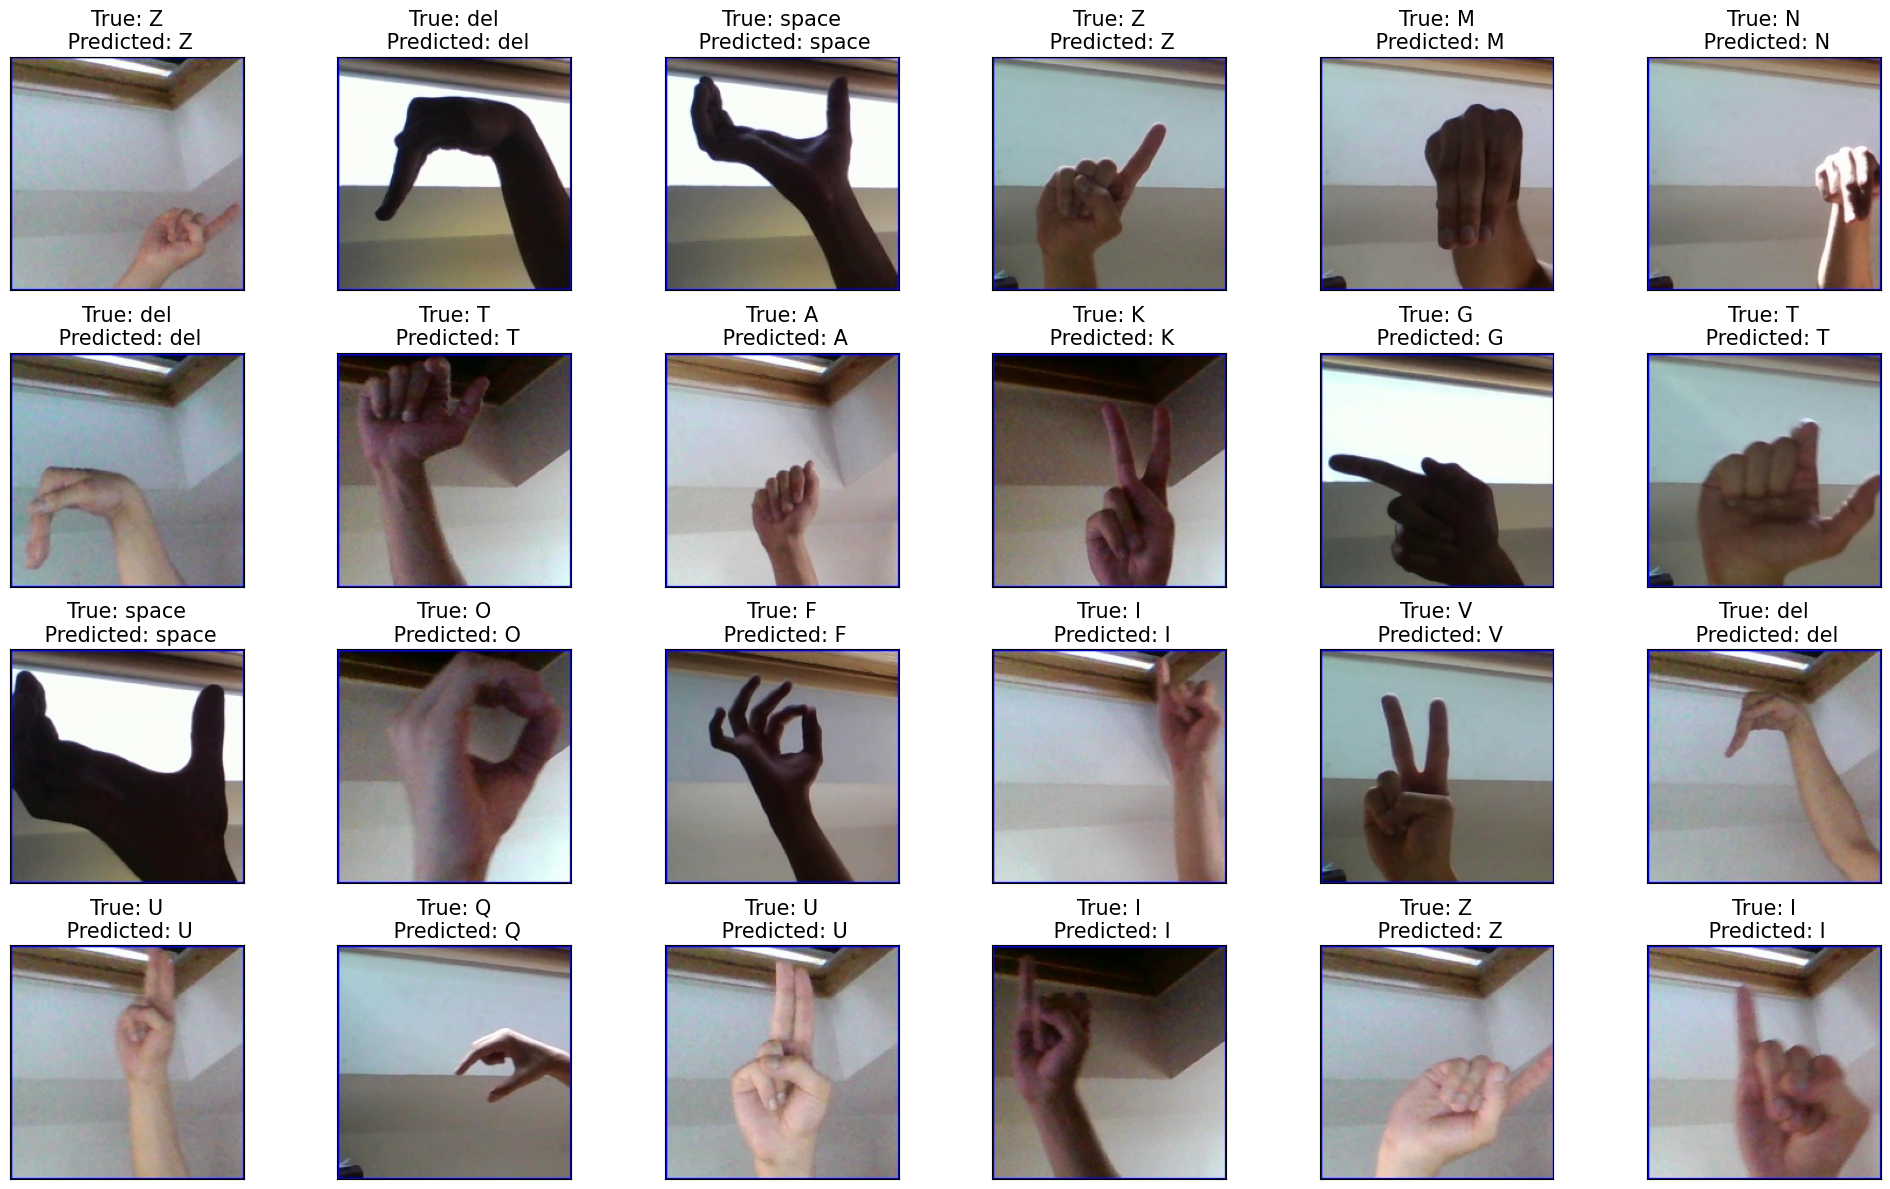

In [31]:
# Display picture of the dataset with their labels
fig, axes = plt.subplots(nrows = 4, ncols = 6, figsize = (20, 12),
                        subplot_kw = {'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f"True: {test_df.Label.iloc[i].split('_')[0]}\n Predicted: {pred[i].split('_')[0]}", fontsize = 15)
plt.tight_layout()
plt.show()